## Comparing [SPCI](https://arxiv.org/abs/2212.03463) with EnbPI - Air Quality Dataset

EnbPI
* Conference version: [ICML 2021](https://proceedings.mlr.press/v139/xu21h.html)
* Extended journal version: [IEEE TPAMI](https://ieeexplore.ieee.org/abstract/document/10121511)

**Dataset**: Air Quality from UCI Machine Learning Repository
* Target: Benzene concentration (C6H6) in µg/m³
* Features: Gas sensor readings (PT08.S1-S5), Temperature, Relative Humidity, Absolute Humidity
* Frequency: Hourly measurements from Italian city (March 2004 - February 2005)


In [1]:
# Uninstall everything related to the project to clear the conflict
%pip uninstall -y numpy scipy scikit-learn sklearn-quantile skranger statsmodels pandas


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2
Found existing installation: sklearn_quantile 0.0.32
Uninstalling sklearn_quantile-0.0.32:
  Successfully uninstalled sklearn_quantile-0.0.32
Found existing installation: skranger 0.8.0
Uninstalling skranger-0.8.0:
  Successfully uninstalled skranger-0.8.0
Found existing installation: statsmodels 0.14.5
Uninstalling statsmodels-0.14.5:
  Successfully uninstalled statsmodels-0.14.5
Found existing installation: pandas 2.3.3
Uninstalling pandas-2.3.3:
  Successfully uninstalled pandas-2.3.3
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reinstall with a strict ban on NumPy 2.0
%pip install "numpy<2.0" pandas scikit-learn sklearn-quantile skranger matplotlib scipy


  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached sklearn_quantile-0.1.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.8 kB)
  Using cached skranger-0.8.0-cp310-cp310-macosx_10_15_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.15.3-cp310-cp310-macosx_14_0_x86_64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of sklearn-quantile to determine which version is compatible with other requirements. This could take a while.
  Using cached sklearn_quantile-0.1.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
  Using cached sklearn_quantile-0.0.32-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl (11.6 MB)
Using cached scikit_l

In [3]:
# Correct spelling: statsmodels
%pip install statsmodels


  Using cached statsmodels-0.14.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (9.5 kB)
Using cached statsmodels-0.14.5-cp310-cp310-macosx_10_9_x86_64.whl (10.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Data loader function for Air Quality
import pandas as pd
import numpy as np

def load_air_quality_dataset():
    """
    Loads Air Quality dataset.
    Returns: X (features), Y (target) as numpy arrays.
    """
    # Load with semicolon separator and comma as decimal
    df = pd.read_csv('Data/AirQualityUCI.csv', sep=';', decimal=',')
    
    # Drop empty columns (often generated by trailing ;;)
    df = df.dropna(how='all', axis=1)
    # Drop rows with all NaNs
    df = df.dropna(how='all', axis=0)
    
    # The dataset uses -200 to mark missing values. Replace with NaN and drop
    df = df.replace(-200.0, np.nan).dropna()
    
    # Target: C6H6(GT) (Benzene concentration) is a robust target
    target_col = 'C6H6(GT)'
    Y = df[target_col].values.astype(float)
    
    # Features: Drop Date, Time, and Target
    drop_cols = ['Date', 'Time', target_col]
    # Filter strictly to columns present
    existing_drop = [c for c in drop_cols if c in df.columns]
    X = df.drop(columns=existing_drop).values.astype(float)
    
    print(f"Loaded {len(Y)} samples with {X.shape[1]} features")
    print(f"Feature columns: {df.drop(columns=existing_drop).columns.tolist()}")
    
    return X, Y


### To use [EnbPI](https://arxiv.org/abs/2010.09107), which is fast

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For EnbPI, larger `past_window` will make intervals wider.


In [5]:
# Define or get data
import torch

# Load air quality data
X_numpy, Y_numpy = load_air_quality_dataset()
X_full = torch.from_numpy(X_numpy).float()
Y_full = torch.from_numpy(Y_numpy).float()

print('Full data shape')
print(X_full.shape, Y_full.shape)

# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]

# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')


Loaded 827 samples with 12 features
Feature columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Full data shape
torch.Size([827, 12]) torch.Size([827])
We will thus construct 166 prediction intervals during test time


In [6]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI

fit_func = RandomForestRegressor(n_estimators=10, max_depth=2, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
EnbPI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
EnbPI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval


1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.8549671173095703 secs.


In [7]:
use_SPCI = False
smallT = not use_SPCI
EnbPI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=False, stride=stride)
results = EnbPI_class_.get_results(alpha, 'air_quality', 1)


Shape of slided residual lists is (166, 300)
Finish Computing 166 UNIQUE Prediction Intervals, took 0.13586711883544922 secs.
Average Coverage is 0.927710843373494
Average Width is 5.414664991048122


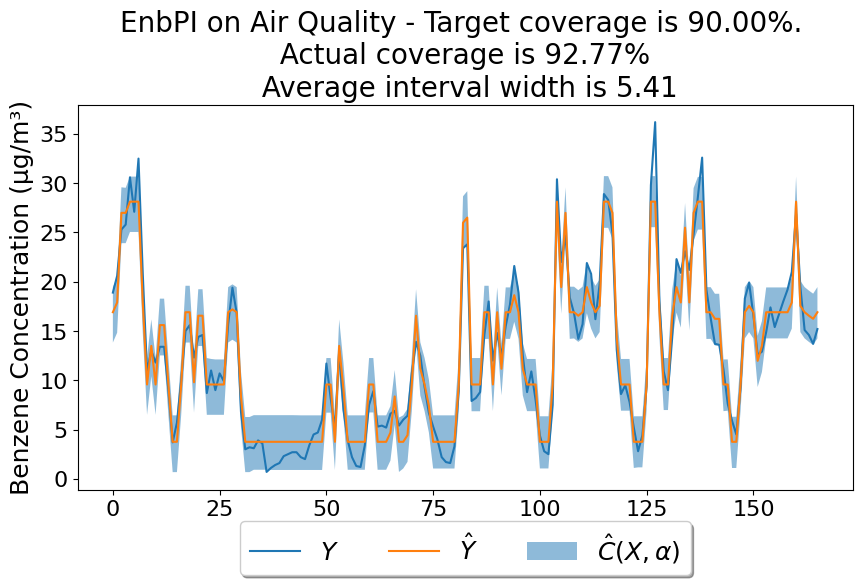

In [8]:
# Plot prediction intervals on test sample
Pred_ints = EnbPI_class_.PIs_Ensemble
Y_est = EnbPI_class_.Ensemble_pred_interval_centers
Y_predict = EnbPI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('Benzene Concentration (µg/m³)')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'EnbPI on Air Quality - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')
plt.show()


### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.


In [9]:
# Define or get data
import torch

# Load air quality data
X_numpy, Y_numpy = load_air_quality_dataset()
X_full = torch.from_numpy(X_numpy).float()
Y_full = torch.from_numpy(Y_numpy).float()

print('Full data shape')
print(X_full.shape, Y_full.shape)

# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]

# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')


Loaded 827 samples with 12 features
Feature columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Full data shape
torch.Size([827, 12]) torch.Size([827])
We will thus construct 166 prediction intervals during test time


In [10]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI

fit_func = RandomForestRegressor(n_estimators=10, max_depth=2, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
SPCI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval


1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.8272039890289307 secs.


In [11]:
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'air_quality', 1)


Shape of slided residual lists is (166, 661)
Width at test 0 is 5.611763000488281
Width at test 8 is 5.405116081237793
Width at test 16 is 5.258885860443115
Width at test 24 is 5.041802644729614
Width at test 32 is 5.449157953262329
Width at test 40 is 5.205503463745117
Width at test 48 is 5.426933765411377
Width at test 56 is 5.6634681224823
Width at test 64 is 5.345478773117065
Width at test 72 is 5.837873697280884
Width at test 80 is 5.291674375534058
Width at test 88 is 6.060548543930054
Width at test 96 is 5.4103147983551025
Width at test 104 is 4.8684282302856445
Width at test 112 is 5.2956764698028564
Width at test 120 is 5.2089948654174805
Width at test 128 is 5.339754104614258
Width at test 136 is 5.426123857498169
Width at test 144 is 5.315983295440674
Width at test 152 is 5.378323316574097
Width at test 160 is 5.511129379272461
Finish Computing 166 UNIQUE Prediction Intervals, took 18.277568101882935 secs.
Average Coverage is 0.8493975903614458
Average Width is 5.43058053628

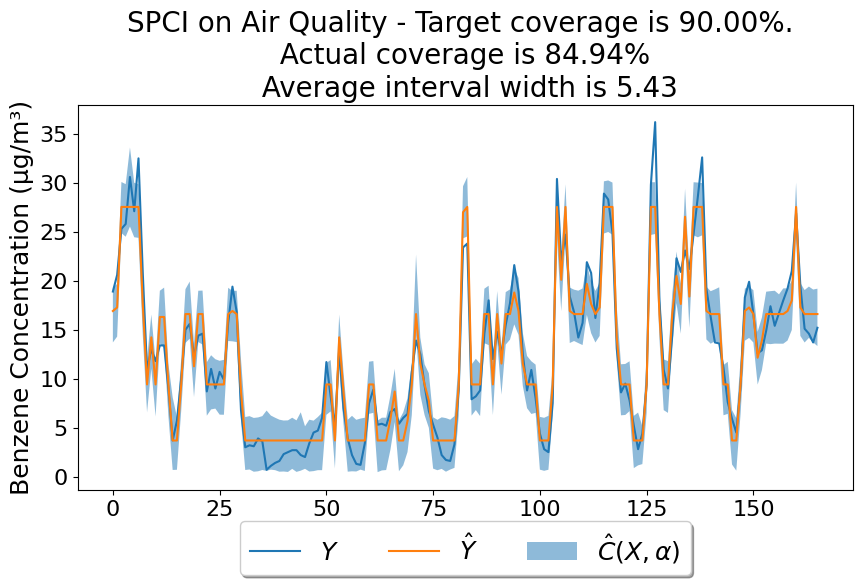

In [12]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('Benzene Concentration (µg/m³)')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'SPCI on Air Quality - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')
plt.show()
